In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Here, we are normalizing the pixel values to the range [0, 1]
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Set the batch size for the data generator
batch_size = 32

# Define the directories for the train, validation, and test sets
train_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/train'
validation_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/validation'
test_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/test'

# Specify the class names explicitly as strings
class_names = ['anger','contempt','disgust','fear','happy','neutral','sad','surprise']

# Create the image generators for the train, validation, and test sets
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 31919 images belonging to 8 classes.
Found 5634 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


# CNN

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 8

# Define the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Set dropout rate to 20%
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

# Define the checkpoint path to save the best model based on validation accuracy
checkpoint_path = "/kaggle/working/model_checkpoint.h5"

# Define a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model with the defined checkpoint callback
history = model.fit(train_generator, validation_data=validation_generator, epochs=40, callbacks=[checkpoint])

# Load the best model based on validation accuracy
model.load_weights(checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [4]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 7s 57ms/step
Confusion Matrix:
[[194  16  69  35  12  97  55  22]
 [ 44  80  41  20 117 128  41  29]
 [ 77  15 170  32  41  57  69  39]
 [ 23   2  10 243  20  47  44 111]
 [ 15  23  27  12 339  36  19  29]
 [ 63  31  24  45  27 196  63  51]
 [ 45  12  44  38  29  93 203  36]
 [ 25   6  18 118  35  75  34 189]]


In [5]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


125/125 [==============================] - 7s 55ms/step
              precision    recall  f1-score   support

       anger       0.40      0.39      0.39       500
    contempt       0.43      0.16      0.23       500
     disgust       0.42      0.34      0.38       500
        fear       0.45      0.49      0.47       500
       happy       0.55      0.68      0.61       500
     neutral       0.27      0.39      0.32       500
         sad       0.38      0.41      0.39       500
    surprise       0.37      0.38      0.38       500

    accuracy                           0.40      4000
   macro avg       0.41      0.40      0.40      4000
weighted avg       0.41      0.40      0.40      4000



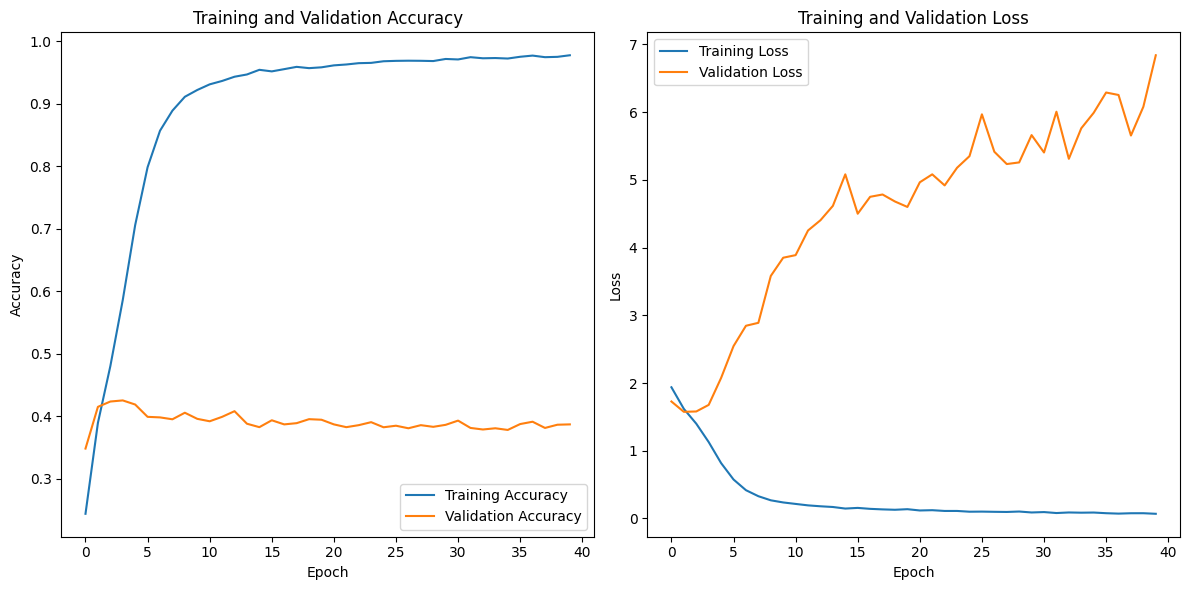

In [6]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# CNN Model1

In [7]:
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 8

# Build the model
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# Define the optimizer and compile the model
optimizer = RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define the checkpoint path to save the best model based on validation accuracy
checkpoint_path = "/kaggle/working/model1_checkpoint.h5"

# Define a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model with the defined checkpoint callback
history = model.fit(train_generator, validation_data=validation_generator, epochs=60, callbacks=[checkpoint])

# Load the best model based on validation accuracy
model.load_weights(checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)    

2023-10-22 08:00:29.128418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


998/998 [==============================] - ETA: 0s - loss: 2.2917 - accuracy: 0.1449
Epoch 1: val_accuracy improved from -inf to 0.14590, saving model to /kaggle/working/model1_checkpoint.h5
998/998 [==============================] - 324s 318ms/step - loss: 2.2917 - accuracy: 0.1449 - val_loss: 2.6345 - val_accuracy: 0.1459
Epoch 2/60
998/998 [==============================] - ETA: 0s - loss: 2.0011 - accuracy: 0.2232
Epoch 2: val_accuracy improved from 0.14590 to 0.28541, saving model to /kaggle/working/model1_checkpoint.h5
998/998 [==============================] - 315s 316ms/step - loss: 2.0011 - accuracy: 0.2232 - val_loss: 1.8351 - val_accuracy: 0.2854
Epoch 3/60
998/998 [==============================] - ETA: 0s - loss: 1.7669 - accuracy: 0.3266
Epoch 3: val_accuracy improved from 0.28541 to 0.37558, saving model to /kaggle/working/model1_checkpoint.h5
998/998 [==============================] - 319s 319ms/step - loss: 1.7669 - accuracy: 0.3266 - val_loss: 1.6224 - val_accuracy: 0

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 8s 62ms/step
Confusion Matrix:
[[211  30  54  23  10 101  40  31]
 [ 29 233  18   4  77 100  14  25]
 [ 72  24 203  23  28  65  39  46]
 [ 23   5   9 243  15  31  32 142]
 [  2  75   5   3 361  17  10  27]
 [ 32  74   9  11  18 257  34  65]
 [ 33  21  19  30  21 116 222  38]
 [ 10  12  10  69  31  48  13 307]]


In [10]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


125/125 [==============================] - 8s 63ms/step
              precision    recall  f1-score   support

       anger       0.51      0.42      0.46       500
    contempt       0.49      0.47      0.48       500
     disgust       0.62      0.41      0.49       500
        fear       0.60      0.49      0.54       500
       happy       0.64      0.72      0.68       500
     neutral       0.35      0.51      0.42       500
         sad       0.55      0.44      0.49       500
    surprise       0.45      0.61      0.52       500

    accuracy                           0.51      4000
   macro avg       0.53      0.51      0.51      4000
weighted avg       0.53      0.51      0.51      4000



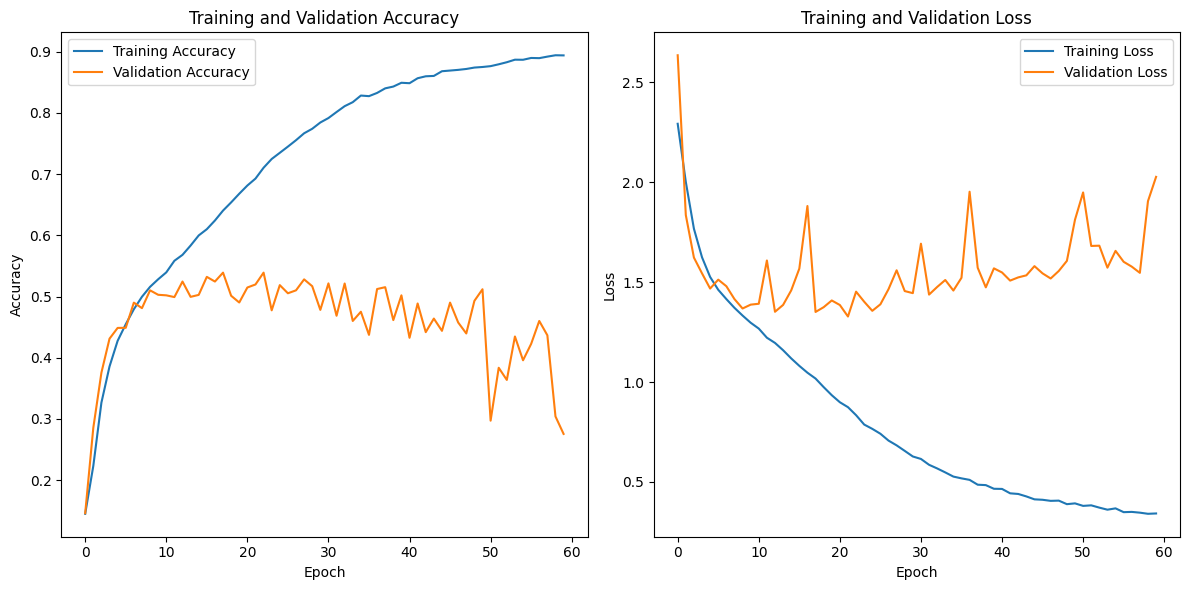

In [11]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# ResNet18

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ResNet-18 architecture
def build_resnet18(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    
    # Initial Convolution Layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    num_blocks = [2, 2, 2, 2]  # Number of residual blocks in each stage
    num_filters = [64, 128, 256, 512]
    
    for stage in range(4):
        for block in range(num_blocks[stage]):
            strides = (1, 1) if stage == 0 and block == 0 else (2, 2)
            y = Conv2D(num_filters[stage], (3, 3), strides=strides, padding='same')(x)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(num_filters[stage], (3, 3), padding='same')(y)
            y = BatchNormalization()(y)
            
            if strides != (1, 1) or stage != 0:
                # Adjust the dimensions of the shortcut connection
                x = Conv2D(num_filters[stage], (1, 1), strides=strides, padding='valid')(x)
            
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
    
    # Global Average Pooling and Fully Connected Layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=x, name='resnet18')
    return model

# Create the ResNet-18 model
input_shape = (224, 224, 3)  
num_classes = 8  
resnet18_model = build_resnet18(input_shape, num_classes)

# Compile the model
resnet18_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
resnet18_model.summary()

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_resnet18.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 50
history = resnet18_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best saved model
resnet18_model.load_weights("best_model_resnet18.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = resnet18_model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 112, 112, 64  256        ['conv2d_8[0][0]']               
 rmalization)                   )                                                          

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = resnet18_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 8s 62ms/step
Confusion Matrix:
[[252  27  42  30   6 108  23  12]
 [ 45 187  17  15  93 100  15  28]
 [138  27 160  50  29  45  28  23]
 [ 33   9   9 301  16  29  18  85]
 [ 13  65   8  13 346  15   9  31]
 [ 65  75  10  28  21 204  36  61]
 [ 73  23  21  70  24 120 146  23]
 [ 29  14   9 147  37  47  17 200]]


In [14]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = resnet18_model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

125/125 [==============================] - 8s 62ms/step
              precision    recall  f1-score   support

       anger       0.39      0.50      0.44       500
    contempt       0.44      0.37      0.40       500
     disgust       0.58      0.32      0.41       500
        fear       0.46      0.60      0.52       500
       happy       0.60      0.69      0.65       500
     neutral       0.31      0.41      0.35       500
         sad       0.50      0.29      0.37       500
    surprise       0.43      0.40      0.42       500

    accuracy                           0.45      4000
   macro avg       0.46      0.45      0.44      4000
weighted avg       0.46      0.45      0.44      4000



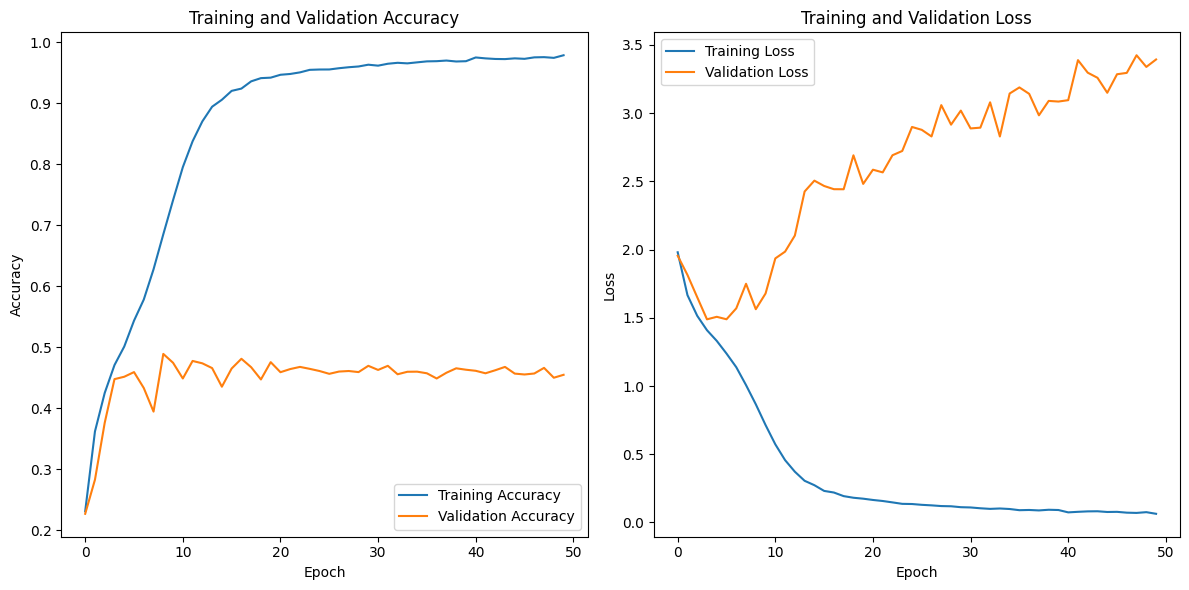

In [15]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# DenseNet121

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the input shape for rgb images
input_shape = (224, 224, 3)

# Define the number of classes in the dataset
num_classes = 8

# Create the DenseNet base model with pre-trained weights (excluding top layers)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Lambda layer to repeat the single-channel grayscale image to three channels
input_tensor = Input(shape=input_shape)
x = (input_tensor)

# Connect the modified input tensor to the base model
x = base_model(x)

# Add custom top layers for classification
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the custom DenseNet model
densenet_model = Model(inputs=input_tensor, outputs=x)

# Compile the model
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
densenet_model.summary()

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_densenet121.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 60
history = densenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best saved model
densenet_model.load_weights("best_model_densenet121.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = densenet_model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                              

In [3]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = densenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 13s 88ms/step
Confusion Matrix:
[[151  23  27  71  24  73  65  66]
 [ 53 136  15  21  99  85  40  51]
 [ 88  23  92  67  67  45  66  52]
 [ 34   7  10 263  22  34  26 104]
 [ 20  49  16  27 310  24  14  40]
 [ 57  66   8  70  39 156  31  73]
 [ 74  28  28  65  30  73 140  62]
 [ 29  10   9 126  45  40  24 217]]


In [4]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = densenet_model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

125/125 [==============================] - 11s 91ms/step
              precision    recall  f1-score   support

       anger       0.30      0.30      0.30       500
    contempt       0.40      0.27      0.32       500
     disgust       0.45      0.18      0.26       500
        fear       0.37      0.53      0.43       500
       happy       0.49      0.62      0.55       500
     neutral       0.29      0.31      0.30       500
         sad       0.34      0.28      0.31       500
    surprise       0.33      0.43      0.37       500

    accuracy                           0.37      4000
   macro avg       0.37      0.37      0.36      4000
weighted avg       0.37      0.37      0.36      4000



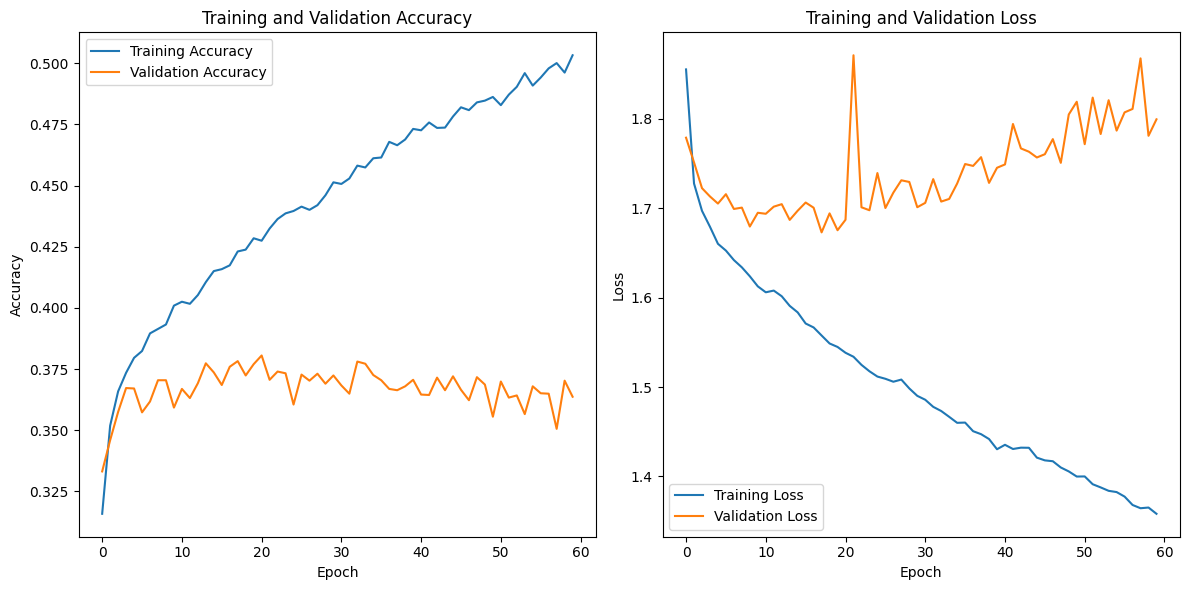

In [5]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the input shape for rgb images
input_shape = (224, 224, 3)

# Define the number of classes in the dataset
num_classes = 8

# Create the DenseNet base model with pre-trained weights (excluding top layers)
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Lambda layer to repeat the single-channel grayscale image to three channels
input_tensor = Input(shape=input_shape)
x = (input_tensor)

# Connect the modified input tensor to the base model
x = base_model(x)

# Add custom top layers for classification
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the custom DenseNet model
densenet_model = Model(inputs=input_tensor, outputs=x)

# Compile the model
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
densenet_model.summary()

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_densenet121.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 60
history = densenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best saved model
densenet_model.load_weights("best_model_densenet121.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = densenet_model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_284 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                              

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = densenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = densenet_model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# VGG16

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 8
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all layers in the base model non-trainable
for layer in base_model.layers:
    layer.trainable = True

model1 = Sequential()
model1.add(base_model)
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(num_classes, activation='softmax'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model1.summary()

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_vgg16.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 100
history = model1.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best saved model
model1.load_weights("best_model_vgg16.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 17,927,112
Trainable params: 17,927,112
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
998/998 [=====================

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model1.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model1.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

In [ ]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# InceptionV3

In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical

#Define the input shape of your grayscale images
input_shape = (224, 224, 3)

# Define the number of classes in your dataset
num_classes = 8

# Set the batch size for the data generator
batch_size = 32

base_model = InceptionV3(include_top=False,input_shape=(224, 224, 3))

# Make all layers in the base model non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Define the model architecture
model3 = Sequential()
model3.add(base_model)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(num_classes, activation='softmax'))

# Compile the model
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_inceptionv3.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 30
history = model3.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[checkpoint])

# Load the best saved model
model3.load_weights("best_model_inceptionv3.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/30
998/998 [==============================] - 93s 87ms/step - loss: 1.9002 - accuracy: 0.2668 - val_loss: 1.8030 - val_accuracy: 0.3143
Epoch 2/30
998/998 [==============================] - 82s 82ms/step - loss: 1.8028 - accuracy: 0.3103 - val_loss: 1.7765 - val_accuracy: 0.3387
Epoch 3/30
998/998 [==============================] - 82s 82ms/step - loss: 1.7685 - accuracy: 0.3274 - val_loss: 1.7495 - val_accuracy: 0.3506
Epoch 4/30
998/998 [==============================] - 82s 82ms/step - loss: 1.7412 - accuracy: 0.3376 - val_loss: 1.7428 - val_accuracy: 0.3506
Epoch 5/30
998/998 [==============================] - 82s 82ms/step - loss: 1.7179 - accuracy: 0.3486 - val_loss: 1.7323 - val_accuracy: 0.3493
Epoch 6/30
998/998 [==============================] - 86s 86ms/step - loss: 1.6979 - accuracy: 0.3571 - val_loss: 1.7327 - val_accuracy: 0.3543
Epoch 7/30
998/998 [==============================] - 81s 81ms/step - l

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model3.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test seta
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 10s 64ms/step
Confusion Matrix:
[[190  32  35  45  36  55  53  54]
 [ 66 126   6  23 125  78  36  40]
 [102  19  90  56  73  34  63  63]
 [ 56   5   5 227  25  24  38 120]
 [ 27  47  16  16 294  22  25  53]
 [ 77  64  11  44  53 122  39  90]
 [ 95  21  24  67  36  61 123  73]
 [ 38  22   7 126  39  46  28 194]]


In [13]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model3.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

125/125 [==============================] - 8s 65ms/step
              precision    recall  f1-score   support

       anger       0.29      0.38      0.33       500
    contempt       0.38      0.25      0.30       500
     disgust       0.46      0.18      0.26       500
        fear       0.38      0.45      0.41       500
       happy       0.43      0.59      0.50       500
     neutral       0.28      0.24      0.26       500
         sad       0.30      0.25      0.27       500
    surprise       0.28      0.39      0.33       500

    accuracy                           0.34      4000
   macro avg       0.35      0.34      0.33      4000
weighted avg       0.35      0.34      0.33      4000



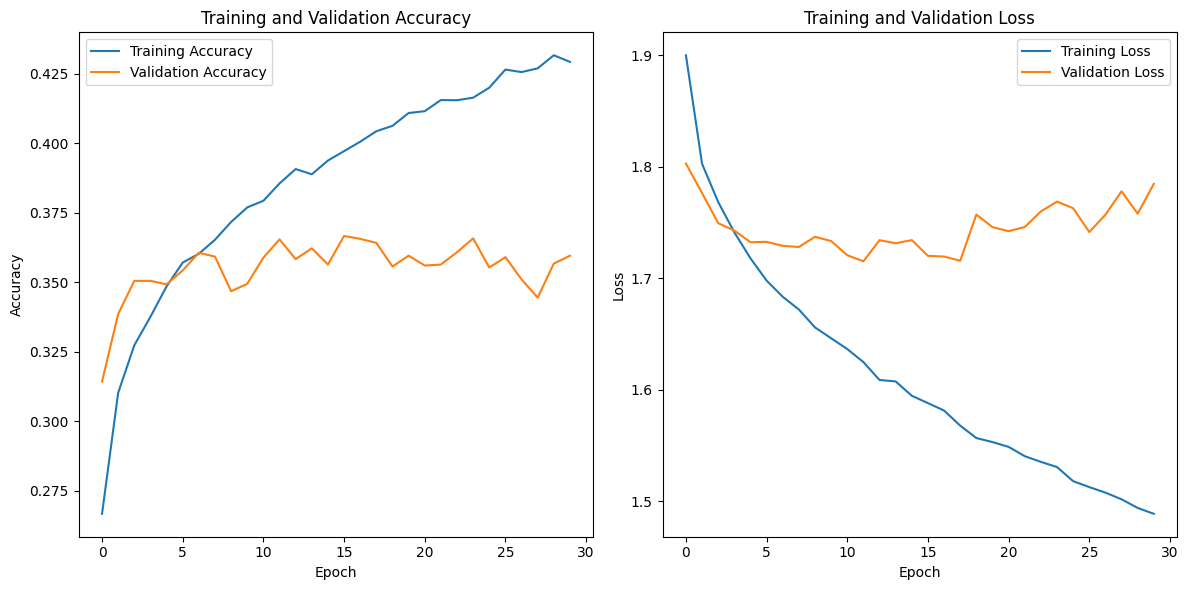

In [14]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical

#Define the input shape of your grayscale images
input_shape = (224, 224, 3)

# Define the number of classes in your dataset
num_classes = 8

# Set the batch size for the data generator
batch_size = 32

base_model = InceptionV3(include_top=False,input_shape=(224, 224, 3))

# Make all layers in the base model non-trainable
for layer in base_model.layers:
    layer.trainable = True

# Define the model architecture
model3 = Sequential()
model3.add(base_model)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(num_classes, activation='softmax'))

# Compile the model
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_inceptionv3.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 30
history = model3.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[checkpoint])

# Load the best saved model
model3.load_weights("best_model_inceptionv3_trainable.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/30
998/998 [==============================] - 273s 237ms/step - loss: 1.6854 - accuracy: 0.3458 - val_loss: 6.0289 - val_accuracy: 0.3064
Epoch 2/30
998/998 [==============================] - 238s 238ms/step - loss: 1.4363 - accuracy: 0.4604 - val_loss: 1.3975 - val_accuracy: 0.4878
Epoch 3/30
998/998 [==============================] - 238s 238ms/step - loss: 1.2995 - accuracy: 0.5184 - val_loss: 1.3061 - val_accuracy: 0.5259
Epoch 4/30
998/998 [==============================] - 237s 238ms/step - loss: 1.2231 - accuracy: 0.5433 - val_loss: 1.3000 - val_accuracy: 0.5339
Epoch 5/30
998/998 [==============================] - 238s 238ms/step - loss: 1.1496 - accuracy: 0.5735 - val_loss: 1.2432 - val_accuracy: 0.5424
Epoch 6/30
998/998 [==============================] - 236s 237ms/step - loss: 1.0868 - accuracy: 0.5999 - val_loss: 1.3254 - val_accuracy: 0.5406
Epoch 7/30
998/998 [==============================] - 237s 238ms/step - loss: 1.0016 - accuracy: 0.6338 - val_loss: 1.2475 -

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'best_model_inceptionv3_trainable.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model3.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test seta
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 13s 92ms/step
Confusion Matrix:
[[210  14  71  38  11  80  54  22]
 [ 30 173  21   5 136  87  37  11]
 [ 67  15 250  21  35  35  63  14]
 [ 22   2  23 286  15  39  58  55]
 [  7  43  13   2 388  23   8  16]
 [ 38  47  10  16  36 246  71  36]
 [ 41  12  15  37  21  76 289   9]
 [ 16  10  27  85  59  64  33 206]]


In [18]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model3.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

125/125 [==============================] - 8s 65ms/step
              precision    recall  f1-score   support

       anger       0.49      0.42      0.45       500
    contempt       0.55      0.35      0.42       500
     disgust       0.58      0.50      0.54       500
        fear       0.58      0.57      0.58       500
       happy       0.55      0.78      0.65       500
     neutral       0.38      0.49      0.43       500
         sad       0.47      0.58      0.52       500
    surprise       0.56      0.41      0.47       500

    accuracy                           0.51      4000
   macro avg       0.52      0.51      0.51      4000
weighted avg       0.52      0.51      0.51      4000



In [19]:
#Save the best model as an .h5 file
model3.save("model3_inceptionv3.h5")  # Save the model as an .h5 file

# EfficientNetV2B0

In [27]:
import tensorflow as tf
base_model = tf.keras.applications.EfficientNetV2B0(include_top = False)
base_model.trainable = True

print(len(base_model.layers))

270


In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import to_categorical

# Define the input shape of your images
input_shape = (224, 224, 3)

# Set the batch size for the data generator
batch_size = 32

base_model = EfficientNetV2B0(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

for layer in base_model.layers[:-255]:
    layer.trainable = False

# Define the model architecture
model4 = Sequential()
model4.add(Conv2D(3, (1, 1), input_shape=(224, 224, 3), activation='relu'))
model4.add(base_model)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(num_classes, activation='softmax'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model4.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_efficientnet.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 60
history = model4.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[checkpoint])

# Load the best saved model
model4.load_weights("best_model_efficientnet.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/60


2023-10-23 07:18:55.270080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


998/998 [==============================] - 217s 190ms/step - loss: 2.0600 - accuracy: 0.1660 - val_loss: 1.9997 - val_accuracy: 0.2141
Epoch 2/60
998/998 [==============================] - 183s 184ms/step - loss: 1.9108 - accuracy: 0.2591 - val_loss: 1.7457 - val_accuracy: 0.3362
Epoch 3/60
998/998 [==============================] - 184s 185ms/step - loss: 1.7173 - accuracy: 0.3408 - val_loss: 1.5942 - val_accuracy: 0.3953
Epoch 4/60
998/998 [==============================] - 184s 184ms/step - loss: 1.5974 - accuracy: 0.3919 - val_loss: 1.4961 - val_accuracy: 0.4386
Epoch 5/60
998/998 [==============================] - 184s 184ms/step - loss: 1.5042 - accuracy: 0.4287 - val_loss: 1.4107 - val_accuracy: 0.4760
Epoch 6/60
998/998 [==============================] - 183s 184ms/step - loss: 1.4302 - accuracy: 0.4639 - val_loss: 1.3714 - val_accuracy: 0.4961
Epoch 7/60
998/998 [==============================] - 184s 184ms/step - loss: 1.3640 - accuracy: 0.4927 - val_loss: 1.3235 - val_accura

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model4.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test seta
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 9s 63ms/step
Confusion Matrix:
[[234  12  65  28   8  60  74  19]
 [ 36 179  26   6 107  94  29  23]
 [ 78  16 227  28  23  29  71  28]
 [ 30   6  12 295  14  18  54  71]
 [  4  49  10   7 376  15  13  26]
 [ 52  46  24  27  15 217  76  43]
 [ 46  16  26  34  18  63 276  21]
 [ 15  11  17 102  32  54  36 233]]


In [31]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model4.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

125/125 [==============================] - 8s 64ms/step
              precision    recall  f1-score   support

       anger       0.47      0.47      0.47       500
    contempt       0.53      0.36      0.43       500
     disgust       0.56      0.45      0.50       500
        fear       0.56      0.59      0.57       500
       happy       0.63      0.75      0.69       500
     neutral       0.39      0.43      0.41       500
         sad       0.44      0.55      0.49       500
    surprise       0.50      0.47      0.48       500

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000



In [32]:
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_284 (Conv2D)         (None, 224, 224, 3)       12        
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 128)               163968    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 8)                

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import to_categorical

# Define the input shape of your images
input_shape = (224, 224, 3)

# Set the batch size for the data generator
batch_size = 32

base_model = EfficientNetV2B0(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

for layer in base_model.layers[:-265]:
    layer.trainable = False

# Define the model architecture
model4 = Sequential()
model4.add(Conv2D(3, (1, 1), input_shape=(224, 224, 3), activation='relu'))
model4.add(base_model)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(num_classes, activation='softmax'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model4.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_efficientnet1.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 60
history = model4.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[checkpoint])

# Load the best saved model
model4.load_weights("best_model_efficientnet1.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model4.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test seta
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model4.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

In [ ]:
model4.summary()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import to_categorical

# Define the input shape of your images
input_shape = (224, 224, 3)

# Set the batch size for the data generator
batch_size = 32

base_model = EfficientNetV2B0(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

for layer in base_model.layers[:-255]:
    layer.trainable = True

# Define the model architecture
model4 = Sequential()
model4.add(Conv2D(3, (1, 1), input_shape=(224, 224, 3), activation='relu'))
model4.add(base_model)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(num_classes, activation='softmax'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model4.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_efficientnet2.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 60
history = model4.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[checkpoint])

# Load the best saved model
model4.load_weights("best_model_efficientnet2.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model4.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test seta
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model4.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# VGG19

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
#base_model.trainable = False

# Make all layers in the base model non-trainable
for layer in base_model.layers:
    layer.trainable = True
    
# Repeat the grayscale channel three times
model_vgg19 = Sequential()
model_vgg19.add(base_model)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(128, activation='relu'))
model_vgg19.add(Dropout(0.3))
model_vgg19.add(Dense(num_classes, activation='softmax'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model_vgg19.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model_vgg19.summary()

# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_vgg19.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 100
history_vgg19 = model_vgg19.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best saved model
model_vgg19.load_weights("best_model_vgg19.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model_vgg19.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model_vgg19.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test seta
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model_vgg19.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam

new_model = Sequential()

new_model.add(Conv2D(64, (3,3), padding='same', input_shape=(224,224,3)))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(MaxPooling2D((2,2)))
new_model.add(Dropout(0.25))

new_model.add(Conv2D(128, (5,5), padding='same'))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(MaxPooling2D((2,2)))
new_model.add(Dropout(0.25))

new_model.add(Conv2D(512, (3,3), padding='same'))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(MaxPooling2D((2,2)))
new_model.add(Dropout(0.25))

new_model.add(Conv2D(512, (3,3), padding='same'))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(MaxPooling2D((2,2)))
new_model.add(Dropout(0.25))
          
new_model.add(Flatten())
          
new_model.add(Dense(256))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(Dropout(0.25))
          
new_model.add(Dense(512))
new_model.add(BatchNormalization())
new_model.add(Activation('relu'))
new_model.add(Dropout(0.25))
          
new_model.add(Dense(8, activation='softmax'))

new_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00025), metrics=['accuracy'])

new_model.summary()

from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, verbose=1)
model_checkpoint = ModelCheckpoint('new_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max', verbose=1)

history = new_model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = new_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = new_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test seta
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = new_model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 8
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all layers in the base model non-trainable
for layer in base_model.layers:
    layer.trainable = True

# Repeat the grayscale channel three times
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model2.summary()
# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_resnet50.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 40
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best saved model
model2.load_weights("best_model_resnet50.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model2.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model2.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# Vision Transformers

In [20]:
!pip install vit_keras

In [21]:
from vit_keras import vit

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [22]:
import tensorflow as tf
import tensorflow_addons as tfa
from vit_keras import vit

In [23]:
from vit_keras import vit

# Define the image size
image_size = 224

# Define the number of classes
num_classes = 8

# Build the Vision Transformer model
vit_model = vit.vit_b32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    pretrained_top=False,
    include_top=False,
    classes=len(class_names)  # Use len(class_names) for the number of classes
)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(image_size, image_size, 3)),
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(11, activation=tfa.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
],
    name='vision_transformer'
)

# Compile the model
learning_rate = 1e-4
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)


# Define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=2,
    verbose=1,
    min_delta=1e-4,
    min_lr=1e-6,
    mode='max'
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-4,
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

callbacks = [earlystopping, reduce_lr, checkpointer]

# Train the model
step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = validation_generator.n // validation_generator.batch_size

# Define a callback to save the best model based on validation accuracy
vit_checkpoint = ModelCheckpoint("best_model_vit.h5", monitor="val_accuracy", mode="max", save_best_only=True)


history = model.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=validation_generator,
    validation_steps=step_size_valid,
    epochs=30,
    callbacks=callbacks
)

# Load the best saved ViT model based on validation accuracy
model.load_weights("best_model_vit.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

353253686/353253686 [==============================] - 2s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/30
997/997 [==============================] - ETA: 0s - loss: 1.9273 - accuracy: 0.3318
Epoch 1: val_accuracy improved from -inf to 0.42152, saving model to ./model
997/997 [==============================] - 462s 435ms/step - loss: 1.9273 - accuracy: 0.3318 - val_loss: 1.7648 - val_accuracy: 0.4215 - lr: 1.0000e-04
Epoch 2/30
997/997 [==============================] - ETA: 0s - loss: 1.6979 - accuracy: 0.4678
Epoch 2: val_accuracy improved from 0.42152 to 0.47461, saving model to ./model
997/997 [==============================] - 434s 435ms/step - loss: 1.6979 - accuracy: 0.4678 - val_loss: 1.7168 - val_accuracy: 0.4746 - lr: 1.0000e-04
Epoch 3/30
997/997 [==============================] - ETA: 0s - loss: 1.6112 - accuracy: 0.5254
Epoch 3: val_accuracy improved from 0.47461 to 0.48171, saving model to ./model
997/997 [==============================] - 434s 436ms/step - loss: 1.6112 - accuracy: 0.5254 - val_loss: 1.7218 - val_accuracy: 0.4817 - lr: 1.0000e-04
Epoch 4/30
997/997 

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'best_model_vit.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [24]:
# Save the best model as an .h5 file
model.save("vision_transformer_model.h5")  # Save the model as an .h5 file

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

125/125 [==============================] - 17s 113ms/step
Confusion Matrix:
[[258  20  39  20  12  72  55  24]
 [ 39 215  23   2 110  80  17  14]
 [ 89  18 221  20  23  46  53  30]
 [ 31   4  21 255  15  29  43 102]
 [  6  51  12   4 385  16   5  21]
 [ 40  59  17  17  23 240  61  43]
 [ 60  18  24  36  14  71 258  19]
 [ 23   7  12  58  47  53  26 274]]


In [26]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


125/125 [==============================] - 14s 110ms/step
              precision    recall  f1-score   support

       anger       0.47      0.52      0.49       500
    contempt       0.55      0.43      0.48       500
     disgust       0.60      0.44      0.51       500
        fear       0.62      0.51      0.56       500
       happy       0.61      0.77      0.68       500
     neutral       0.40      0.48      0.43       500
         sad       0.50      0.52      0.51       500
    surprise       0.52      0.55      0.53       500

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.52      4000
weighted avg       0.53      0.53      0.52      4000



In [ ]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory=os.getcwd(), file_name='directory.zip'):
    """
    Zip all the files in a directory
    
    Parameters
    ----------
    directory : str
        Directory to be zipped. Default is the current working directory.
        
    file_name : str
        The name of the zipped file (including .zip). Default is 'directory.zip'.
        
    Returns
    -------
    A hyperlink that can be used to download the zip file.
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

# Define the directory to be zipped (Kaggle working directory)
directory_to_zip = '/kaggle/working'

# Specify the name of the output ZIP file
zip_file_name = 'kaggle_working_directory.zip'

# Zip the directory and provide a download link
zip_link = zip_dir(directory=directory_to_zip, file_name=zip_file_name)
zip_link


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Here, we are normalizing the pixel values to the range [0, 1]
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Set the batch size for the data generator
batch_size = 32

# Define the directories for the train, validation, and test sets
train_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/train'
validation_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/test'
test_directory = '/kaggle/input/affectnet-dataset/AffectNet_train_test/validation'

# Specify the class names explicitly as strings
class_names = ['anger','contempt','disgust','fear','happy','neutral','sad','surprise']

# Create the image generators for the train, validation, and test sets
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 8

# Define the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Set dropout rate to 20%
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

# Define the checkpoint path to save the best model based on validation accuracy
checkpoint_path = "/kaggle/working/model_new_checkpoint.h5"

# Define a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model with the defined checkpoint callback
history = model.fit(train_generator, validation_data=validation_generator, epochs=40, callbacks=[checkpoint])

# Load the best model based on validation accuracy
model.load_weights(checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


In [ ]:
import matplotlib.pyplot as plt

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

num_classes = 8
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Repeat the grayscale channel three times
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))  # Replace num_classes with the number of classes in your dataset

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model2.summary()
# Define a callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model_resnet50.h5", monitor="val_accuracy", mode="max", save_best_only=True)

# Train the model
epochs = 40
history = model2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Load the best saved model
model2.load_weights("best_model_resnet50.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model2.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels of the test set
true_labels = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_probabilities = model.predict(test_generator)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

# Get the true class labels for the test set
y_true_labels = test_generator.classes

# Get the class names
class_names = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))
